# Increment training of Network Embedding

- Introduction : Network Embedding is known as a dimension reduction algorithm to represent and extract features from high-dimension. As we known,typical algorithms like SVD,PCA and MDS if a high-dimension matrix has a slight change we need process dimension reduction again but we do not need to train the network again if we are using network embedding methods to do dimension reduction. 
- Advatages:Due  to this superior characteristics, network emedding method saves a lot of computing resource and can be a fast-changing and real-time method to represent user's features because we only need to train new nodes instead of re-training whole graph.
- Application scenario Take social networks as an example, when new users register and have connections others, the graph of network should be different and we need to have new features to represent those new users like which commmunities they belong to.

This jupyter notebook shows an example of how to do increment training of existing embedding matrix when new nodes appear
: we already have trained embedding network of 290 nodes but now we increment training to know their features and which communitiy they should beglong to 

![](increment_training.png)

In [63]:
import pandas as pd
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt

In [64]:
#### hiper paramter
walk_length=5
num_nodes = 300
echo =15 ### num of sampling from network
overlap_nodes = 2

In [65]:
import pickle

In [66]:
def open_object(path):
    with open(path,'rb') as f:
        return pickle.load(f)

#### 1） reprocessing of the embedding matrix

 open the already trained embedding matrix of 290 nodes we save

In [69]:
embeddings_matrix = open_object('embeddings_matrix.pkl')

In [70]:
# embeddings_matrix

(-10.44101792113814, 17.30947666900191, -8.634133944839181, 9.229955802291574)

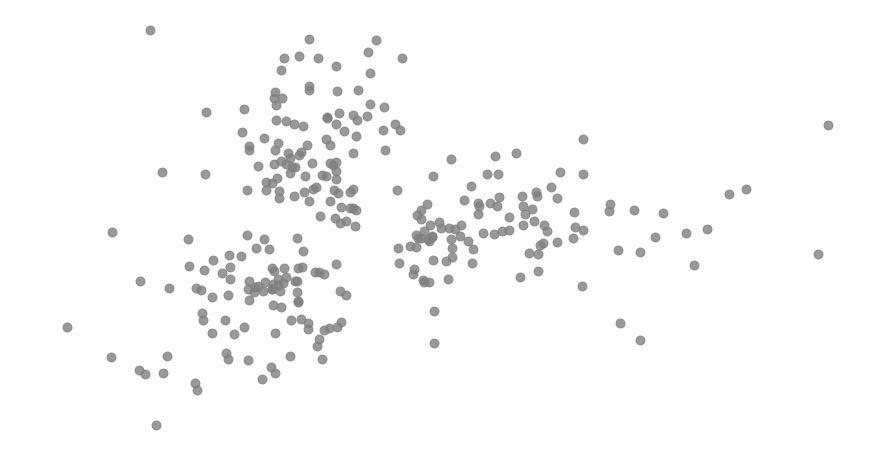

In [71]:
plt.figure(figsize=(15,8))
_ = plt.scatter(embeddings_matrix[:,0],embeddings_matrix[:,1],alpha=0.8,s=80,c='grey')
plt.axis('off')

In [72]:
def show_embedding_matrix():
    x_coords = embeddings_matrix[:,0]
    y_coords = embeddings_matrix[:,1]

    plt.figure(figsize=(15,8))
    _ = plt.scatter(x_coords, y_coords,alpha=0.8,s=80,c='grey')
    for i,node_id in enumerate(list(range(290))):
        x = x_coords[i]
        y = y_coords[i]
        _ =plt.text(x+0.05, y+0.05,node_id)
#     plt.axis('off')
    plt.show()

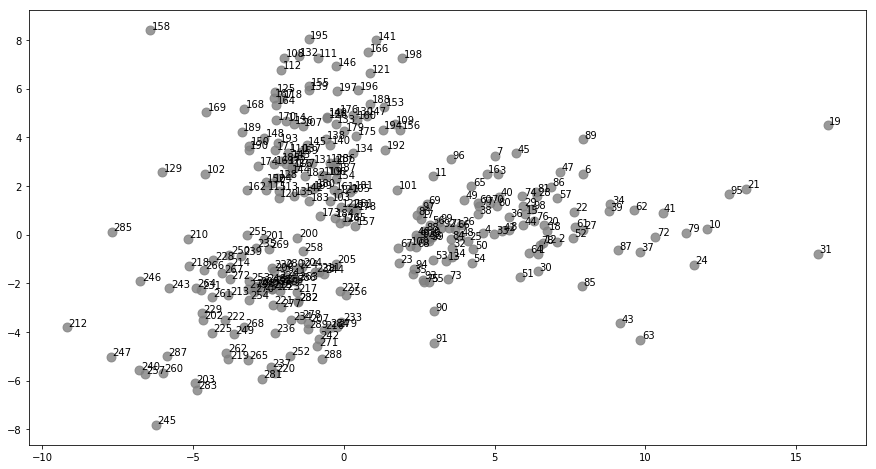

In [73]:
show_embedding_matrix()

In [74]:
embeddings_matrix.shape

(290, 2)

In [75]:
##### open the new adjacency matrix with 10 nodes
adj_matrix_new = open_object('adj_matrix_new.pkl')

In [76]:
adj_matrix_new.shape

(300, 300)

In [77]:
#### open the old adjacency matrix of 290 nodes
adj_matrix_old = open_object('adj_matrix_old.pkl')

In [78]:
adj_matrix_old.shape

(290, 290)

In [15]:
# create the list of edege for visualization
edge_dict ={}

In [16]:
for (node_1,row) in enumerate(adj_matrix_new):
    
    node_list =[]
    
    for (node_2,value) in enumerate(row):
        
        if value==1:
            
            node_list.append(node_2)
    
    edge_dict[node_1]=node_list
            

##### random walk method to extract paths of new nodes for increament training

In [79]:
random_walk_matrix=[]

In [80]:
for _ in range(echo):
    for node in list(edge_dict.keys())[290:]: #### 只取为新节点作为顶点的随机游走路径
        start_point = node
        walk_path = [start_point]

        ### select randomly for echo node
        for _ in range(walk_length-1):
            next_point = random.choice(edge_dict[start_point])  
            walk_path.append(next_point)
            start_point = next_point

        random_walk_matrix.append(walk_path)

In [81]:
random_walk_matrix=np.array(random_walk_matrix)

In [82]:
root = random_walk_matrix[:,2]

root = root.reshape(-1,1)

roots = np.vstack([root for _ in range(walk_length-1)])

In [83]:
left_right = (walk_length-1)//2

i = list(range(walk_length))

i.remove(left_right)

In [84]:
target_nodes =[]

for num in i:
    temp_nodes = random_walk_matrix[:,num].reshape(-1,1)
    target_nodes.append(temp_nodes)

target_nodes = np.vstack(target_nodes)

target_nodes.shape

(600, 1)

In [85]:
roots.shape

(600, 1)

In [86]:
roots_target = np.hstack([roots,target_nodes])

In [87]:
roots_target[:10] ### input_nodes, target_nodes

array([[262, 290],
       [291, 291],
       [231, 292],
       [233, 293],
       [207, 294],
       [295, 295],
       [296, 296],
       [297, 297],
       [236, 298],
       [262, 299]])

In [88]:
boolean_list=[]

In [89]:
for num in roots_target:
    if (num[0] >=290 or num[1]>=290) and not (num[0] >=290 and num[1]>=290):
        boolean_list.append(True)
    else:
        boolean_list.append(False)

In [90]:
roots = roots[boolean_list]

In [91]:
target_nodes = target_nodes[boolean_list]

In [92]:
embeddings_matrix_new = np.random.randn(300,2)

In [93]:
embeddings_matrix_new.shape

(300, 2)

In [94]:
###### copy the trained embedding matrix to new embedding matrix and initialise the values of new nodes

In [95]:
for row in range(embeddings_matrix_new.shape[0]):
    for col in range(embeddings_matrix_new.shape[1]):
        try:
            embeddings_matrix_new[row,col] = embeddings_matrix[row,col]
        except IndexError:
            pass

In [96]:
root = random_walk_matrix[:,2]

root = root.reshape(-1,1)

roots = np.vstack([root for _ in range(walk_length-1)])

In [97]:
left_right = (walk_length-1)//2

i = list(range(walk_length))

i.remove(left_right)

In [98]:
target_nodes =[]

for num in i:
    temp_nodes = random_walk_matrix[:,num].reshape(-1,1)
    target_nodes.append(temp_nodes)

target_nodes = np.vstack(target_nodes)

target_nodes.shape

(600, 1)

In [99]:
batch_size = 64

### increment training

In [100]:
def get_batch(X,Y,batch_size):
    batch_sum = 0
    data_size = X.shape[0]
    loop_size = data_size//batch_size ### 6 
    if loop_size<data_size/batch_size:
        loop_size=loop_size+1
    for i in range(loop_size): ### loop_size = 7: 0,1,2,3,4,5,6
        if (i+1)!=loop_size: ### 6
            x = X[batch_sum:batch_sum+batch_size]
            y = Y[batch_sum:batch_sum+batch_size]
            batch_sum+=batch_size
        else:
            x=X[batch_sum:]
            y=Y[batch_sum:]
        
        yield x,y

In [101]:
import tensorflow as tf
import tensorflow.contrib.slim as slim

In [102]:
def n_gram(inputs, node_size = 500, n_dim=2, scope='skip-gram', reuse=tf.AUTO_REUSE):
    with tf.variable_scope(scope, reuse=reuse):
        with tf.device('/cpu:0'):
            embeddings = tf.get_variable('embeddings', shape=[node_size, n_dim], initializer=tf.constant_initializer(value=embeddings_matrix_new))
        embed = tf.nn.embedding_lookup(embeddings, inputs)
        net = slim.fully_connected(embed,node_size, activation_fn=None, scope='classification')  
        return net,embeddings

In [41]:
input_ph = tf.placeholder(dtype=tf.int64, shape=[None,1], name='input') 
label_ph = tf.placeholder(dtype=tf.int64, shape=[None,1], name='label')

In [42]:
net,embeddings = n_gram(input_ph,num_nodes,n_dim =2) ### 嵌入维度 n_dim

In [43]:
### define the loss fuction
loss = tf.losses.sparse_softmax_cross_entropy(label_ph, net, scope='loss')

In [44]:
# opt = tf.train.MomentumOptimizer(1e-2, 0.9)
opt =tf.train.AdamOptimizer(1e-2)
train_op = opt.minimize(loss)

In [45]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [46]:
def show_embedding_matrix():
    embeddings_matrix = embeddings.eval()
    x_coords = embeddings_matrix[:,0]
    y_coords = embeddings_matrix[:,1]
    colors = ['grey' if num < 290 else 'orange' for num in range(300)]
    plt.figure(figsize=(15,8))
    _ = plt.scatter(x_coords, y_coords,alpha=0.8,s=80,c=colors)
    for i,node_id in enumerate(list(range(num_nodes))):
        x = x_coords[i]
        y = y_coords[i]
        _ =plt.text(x+0.05, y+0.05,node_id)
#     plt.axis('off')
    plt.show()

Epoch: 10, Loss: 4.19810


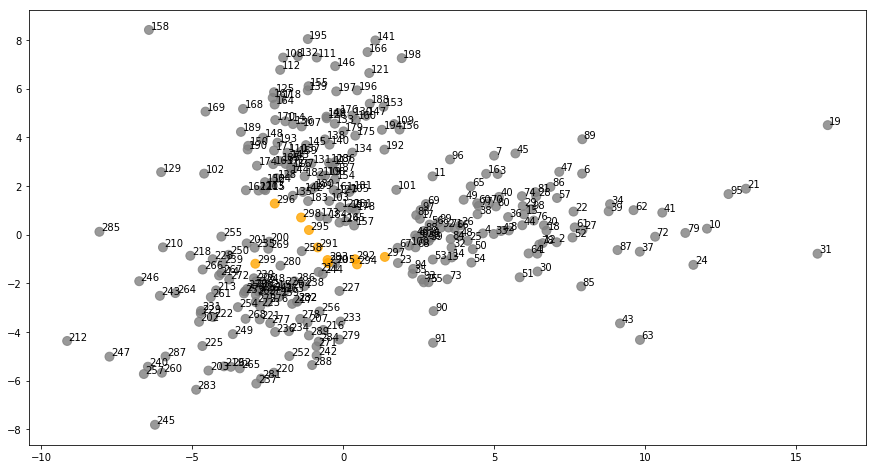

Epoch: 20, Loss: 3.93155


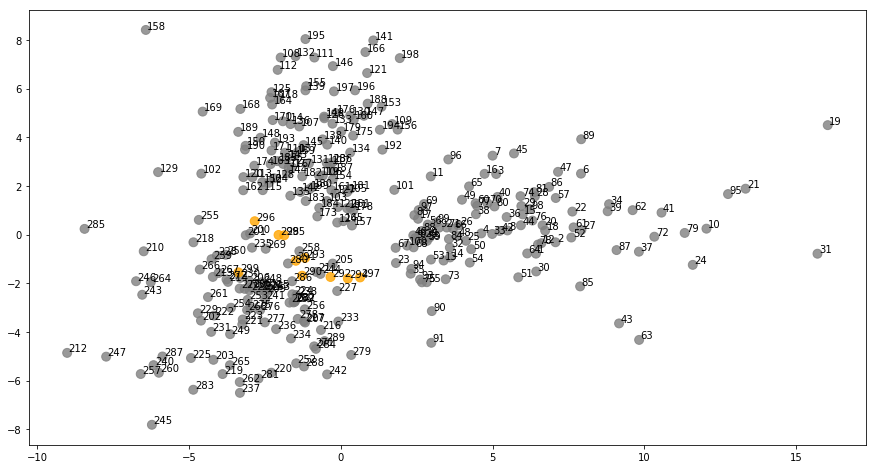

Epoch: 30, Loss: 3.79828


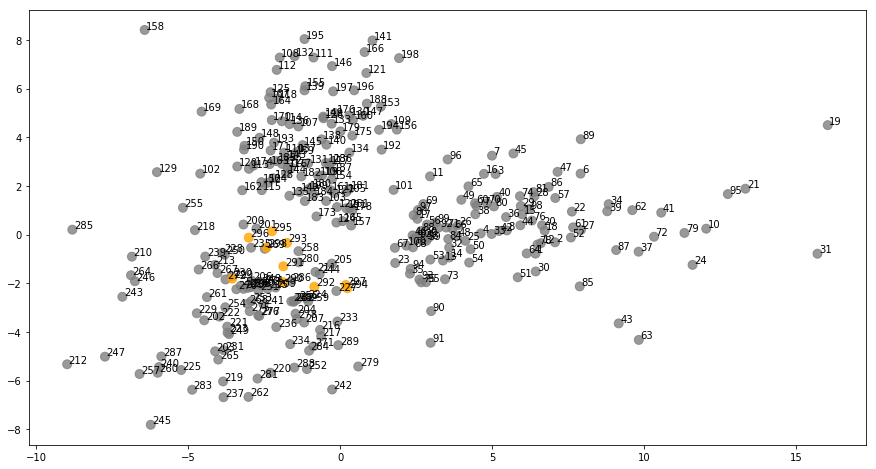

Epoch: 40, Loss: 3.70754


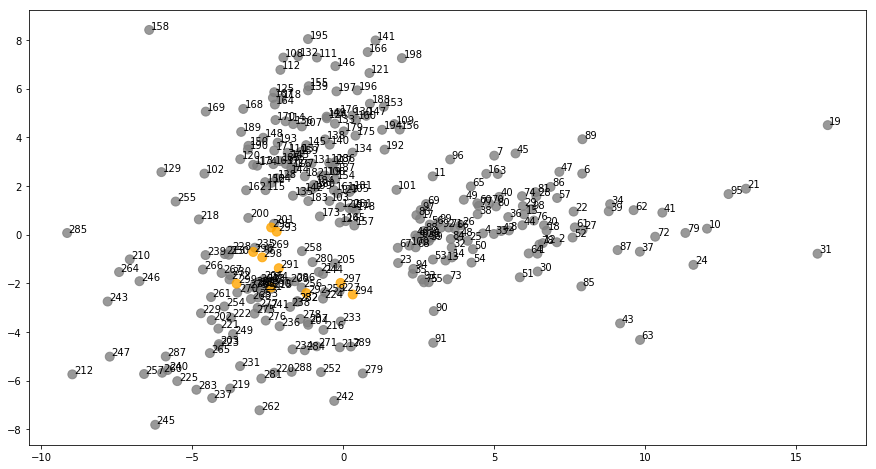

Epoch: 50, Loss: 3.63446


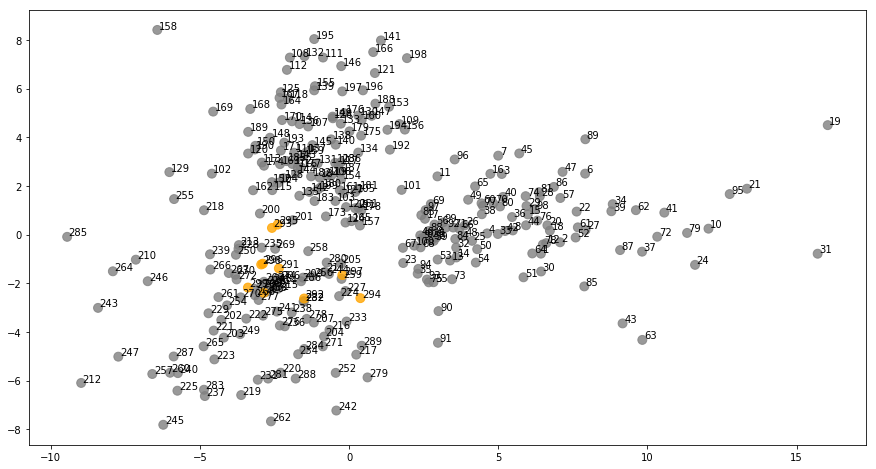

Epoch: 60, Loss: 3.56959


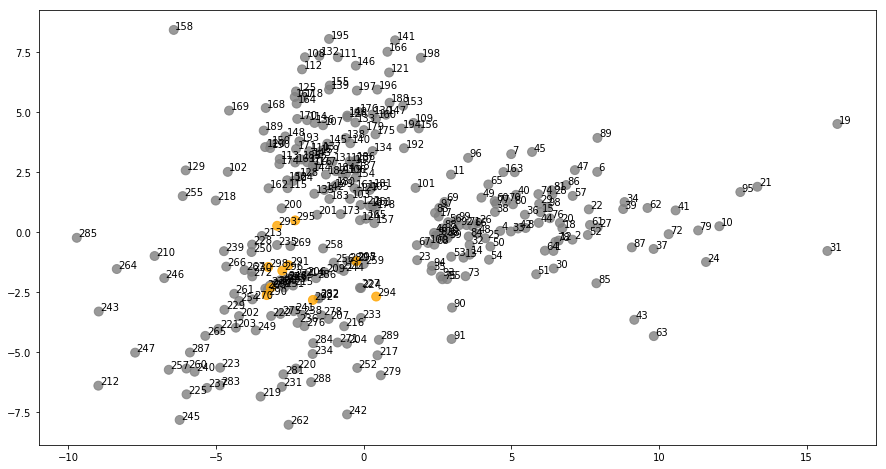

Epoch: 70, Loss: 3.50988


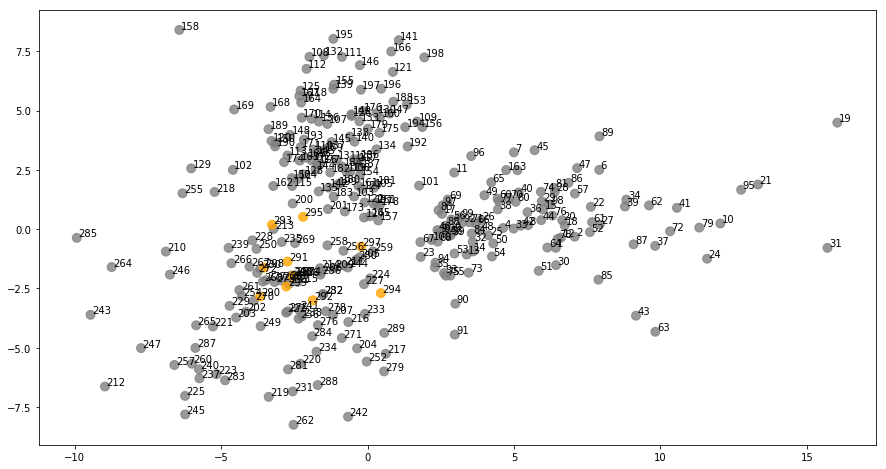

Epoch: 80, Loss: 3.45468


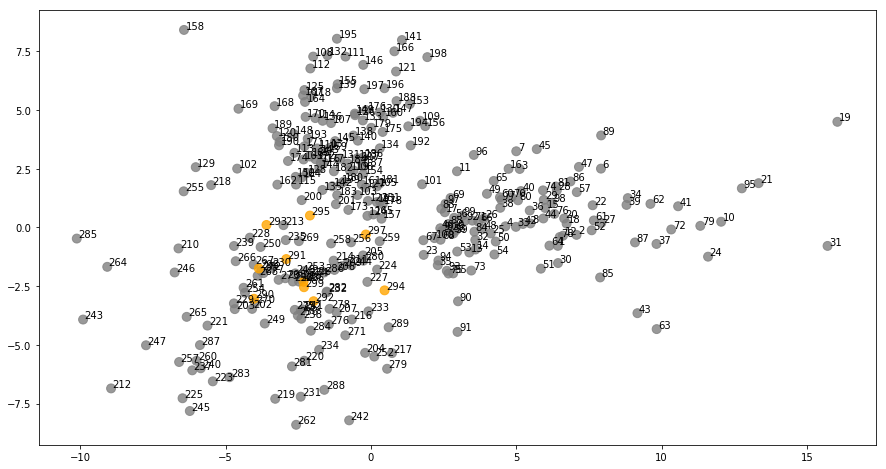

Epoch: 90, Loss: 3.40432


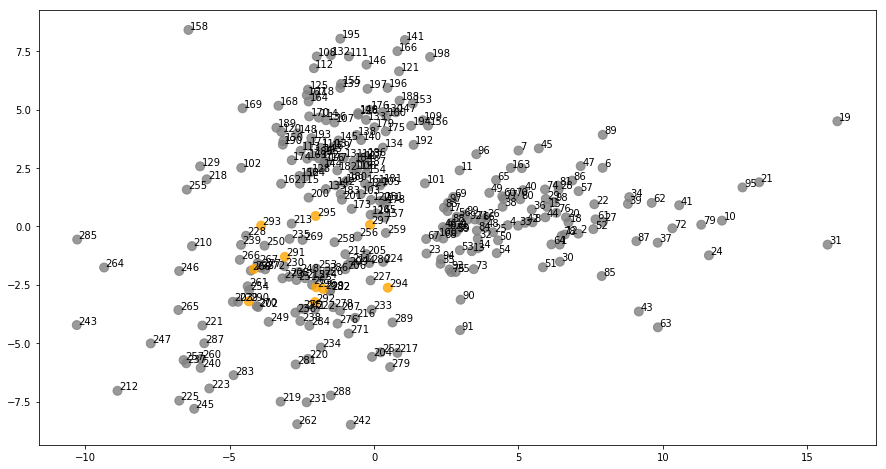

Epoch: 100, Loss: 3.35945


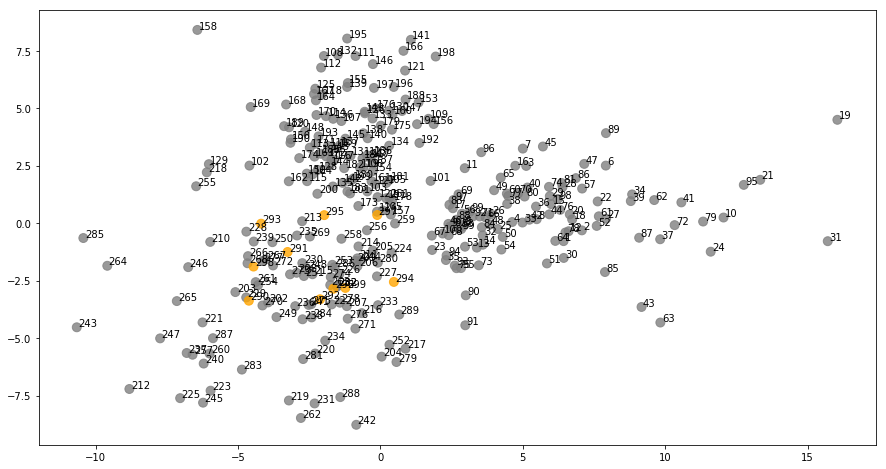

In [47]:
for e in range(100):
    train_losses = []
    
    for path, root in get_batch(roots,target_nodes,batch_size):
        _, curr_loss = sess.run([train_op, loss], feed_dict={input_ph: path, label_ph: root})
        train_losses.append(curr_loss)
        
    if (e + 1) % 10 == 0:
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, np.mean(train_losses)))
        show_embedding_matrix()

In [48]:
edge_dict[297] #### 当新节点连接数目太低不应该纳入模型训练

[258]

In [49]:
edge_dict[291]#### 当新节点连接数目较多模型训练比较好

[225, 241, 246, 267, 272, 283]

In [50]:
embeddings_matrix.shape

(290, 2)

In [51]:
G = nx.Graph()

In [52]:
edge_list = [] #### 边集合

In [53]:
for (node_1,row) in enumerate(adj_matrix_new):
    
    for (node_2,value) in enumerate(row):
        
        if value==1:
            edge_list.append((node_1,node_2))

In [54]:
G.add_edges_from(edge_list)

In [55]:
node_colors = []

In [56]:
num_nodes

300

In [57]:
for num in range(num_nodes):
    if num >= 290:
        node_colors.append('orange')
    else:
        node_colors.append('grey')

In [58]:
len(node_colors)

300

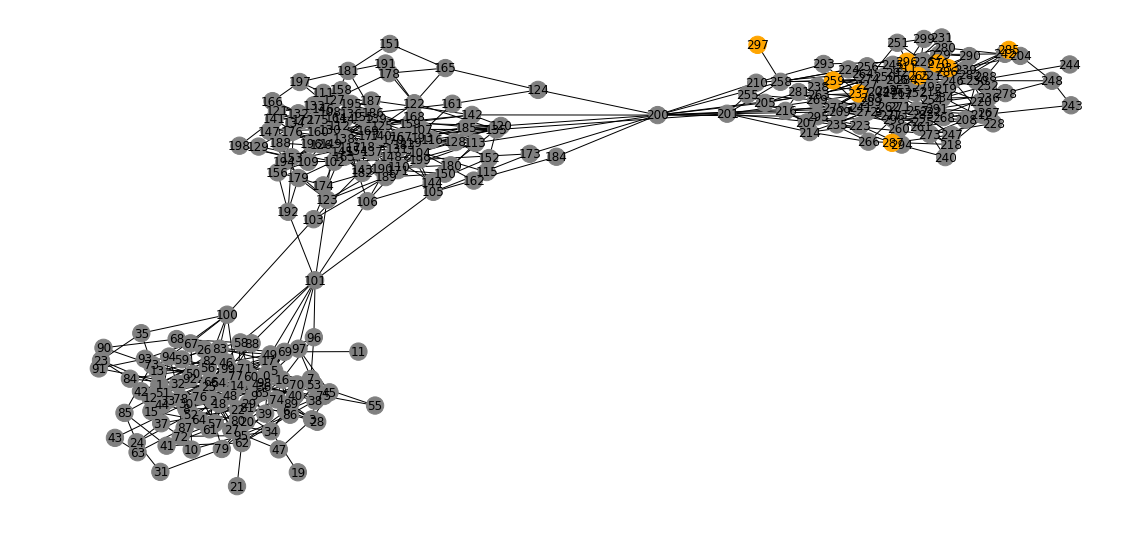

In [59]:
plt.figure(figsize=(15,7))
nx.draw(G,with_labels = True,node_color=node_colors[:-1],)

In [60]:
adj_matrix_new.shape

(300, 300)

300

300

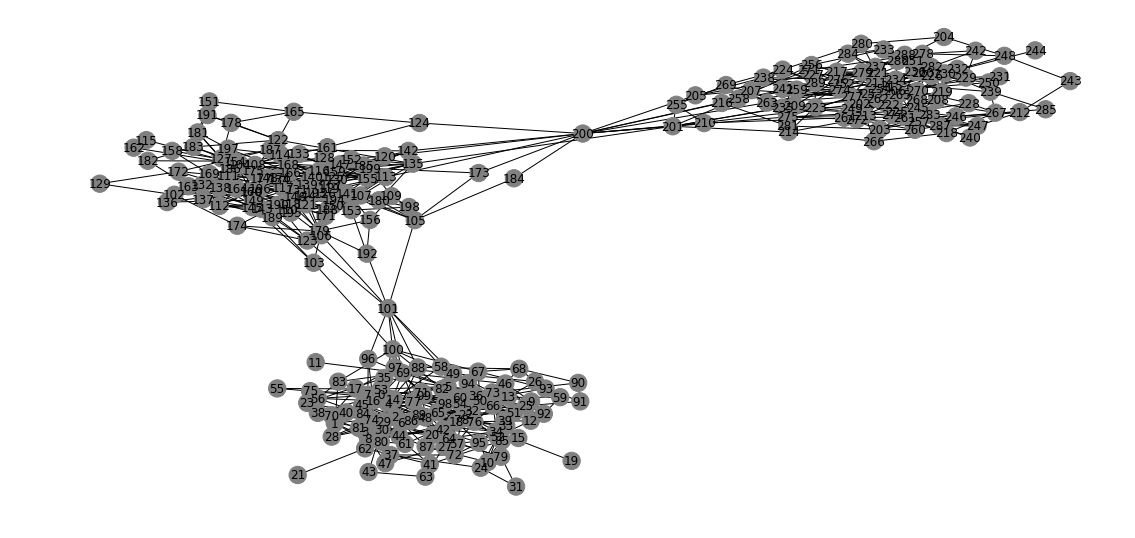

In [61]:
G = nx.Graph()

edge_list = [] #### 边集合

for (node_1,row) in enumerate(adj_matrix_new[:290,:290]):
    
    for (node_2,value) in enumerate(row):
        
        if value==1:
            edge_list.append((node_1,node_2))

G.add_edges_from(edge_list)

node_colors = []

num_nodes

for num in range(num_nodes):
    if num >= 290:
        node_colors.append('orange')
    else:
        node_colors.append('grey')

len(node_colors)

plt.figure(figsize=(15,7))
nx.draw(G,with_labels = True,node_color=node_colors[:-1])